In [22]:
import os

os.environ["KERAS_BACKEND"] = "torch"

import numpy as np

from keras.src.callbacks import History
from keras.src.losses import MeanSquaredError
from keras.src.optimizers import Adam

from src.data.preprocessing import preprocess
from src.plot.image import plot_grid_of_letters

from keras import Sequential, Model

from keras.src.layers import (
    Dense,
    Input,
    MaxPooling2D,
    Conv2DTranspose,
    Conv2D,
    Activation,
    Reshape,
    UpSampling2D,
    Cropping2D,
    Flatten,
)

from src.data.load_data import load_sample_train_test
from matplotlib import pyplot as plt

from src.utils.constants import img_dimension, img_shape_flat, img_shape
from src.utils.misc import init_notebook
from src.models.callbacks import history, early_stopping

In [2]:
init_notebook()

Generator(PCG64) at 0x19AADF666C0

In [3]:
x_train, x_test, y_train, y_test = load_sample_train_test()

In [4]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [5]:
x_train.shape

(2392, 784)

In [79]:
def build_encoder() -> Model:
    # Input
    input_layer = Input(shape=(784,))
    reshape_layer = Reshape((28, 28, 1))(input_layer)

    # Encoder
    conv_layer1 = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(
        reshape_layer
    )  # 28x28x32
    maxpool_layer1 = MaxPooling2D(padding="same")(conv_layer1)  # 14x14x32

    conv_layer2 = Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same")(
        maxpool_layer1
    )  # 28x28x32
    maxpool_layer2 = MaxPooling2D(padding="same")(conv_layer2)  # 14x14x32

    flatten_layer = Flatten()(maxpool_layer2)
    dense_layer = Dense(64)(flatten_layer)

    # Model
    encoder_model = Model(inputs=input_layer, outputs=dense_layer, name="encoder")

    return encoder_model

In [81]:
e = build_encoder()
e.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        50,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,184 (215.56 KB)

 Trainable params: 55,184 (215.56 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
def build_decoder() -> Model:
    # Input
    input_layer = Input(shape=(64,))

    # Decoder
    # Projection vers un tenseur de forme (7, 7, 32)
    x = Dense(7 * 7 * 32, activation="relu")(input_layer)
    x = Reshape((7, 7, 32))(x)

    # Upsampling + convolution transpose pour reconstruire
    x = Conv2DTranspose(
        16, kernel_size=3, strides=2, padding="same", activation="relu"
    )(x)  # -> (14, 14, 16)
    x = Conv2DTranspose(
        32, kernel_size=3, strides=2, padding="same", activation="relu"
    )(x)  # -> (28, 28, 32)

    # Dernière couche pour revenir à 1 canal (grayscale)
    output_img = Conv2DTranspose(
        1, kernel_size=3, padding="same", activation="sigmoid"
    )(x)  # -> (28, 28, 1)

    # Output
    # Flatten pour correspondre à l'entrée (784,)
    output_layer = Reshape((784,))(output_img)

    # Model
    decoder_model = Model(inputs=input_layer, outputs=output_layer, name="decoder")

    return decoder_model

In [99]:
d = build_decoder()
d.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1568)           │       101,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_20 (Reshape)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 14, 14, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 28, 28, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_21 (Reshape)            │ (None, 784)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,473 (435.44 KB)

 Trainable params: 111,473 (435.44 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
def build_auto_encoder() -> tuple[Model, Model, Model]:
    encoder = build_encoder()
    decoder = build_decoder()

    input_layer = encoder.input
    encoded = encoder(input_layer)
    decoded = decoder(encoded)

    auto_encoder = Model(input_layer, decoded)
    auto_encoder.compile(loss=MeanSquaredError(), optimizer=Adam())

    return auto_encoder, encoder, decoder

In [101]:
class AutoEncoder:
    def __init__(self):
        self.autoencoder, self.encoder, self.decoder = build_auto_encoder()
        self.history = history()

    def encode(self, x: np.ndarray) -> np.ndarray:
        return self.encoder.predict(x)

    def decode(self, x: np.ndarray) -> np.ndarray:
        return self.decoder.predict(x)

    def reconstruct(self, x: np.ndarray) -> np.ndarray:
        return self.autoencoder.predict(x)

    def fit(self, x_train: np.ndarray, epochs: int = 10) -> None:
        es = early_stopping()

        self.autoencoder.fit(
            x_train,
            x_train,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[es, self.history],
        )

    def plot_training_curve(self) -> plt.Figure:
        fig = plt.figure()

        plt.plot(self.history.history["loss"], label="MSE loss")
        plt.plot(self.history.history["val_loss"], label="MSE val_loss")

        plt.title("Training curve")
        plt.xlabel("epoch")
        plt.ylabel("loss")

        plt.legend()

        return fig

    def save(self) -> None:
        raise NotImplementedError

    def visualize(self, x: np.ndarray, n: int = 5) -> None:
        # todo: afficher sur 2 colonnes avant / après et sur la troisième colonne la "diff"
        decoded_imgs = self.reconstruct(x[:n])
        diff_imgs = x[:n] - decoded_imgs

        plt.figure(figsize=(8, 4 * n))

        for i in range(n):
            # Original
            ax = plt.subplot(n, 3, i * 3 + 1)
            plt.imshow(x[i].reshape(28, 28), cmap="gray")
            plt.title("Original")
            plt.axis("off")

            # Reconstruit
            ax = plt.subplot(n, 3, i * 3 + 2)
            plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
            plt.title("Reconstruit")
            plt.axis("off")

            # Différence
            ax = plt.subplot(n, 3, i * 3 + 3)
            plt.imshow(
                diff_imgs[i].reshape(28, 28), cmap="seismic", vmin=-1.0, vmax=1.0
            )
            plt.title("Différence")
            plt.axis("off")
        plt.show()

In [103]:
auto_encoder = AutoEncoder()

In [104]:
auto_encoder.fit(x_train)

Epoch 1/10
 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2246

C:\Users\AB2-PC\Documents\GitHub\ab2\recognize-handwritten-letters\.venv\lib\site-packages\keras\src\backend\common\backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1504 - val_loss: 0.0747
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0745 - val_loss: 0.0728
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0726 - val_loss: 0.0685
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0649 - val_loss: 0.0537
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0485 - val_loss: 0.0401
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0353 - val_loss: 0.0255
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0228 - val_loss: 0.0202
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0184 - val_loss: 0.0173
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0133 - val_loss: 0.0141


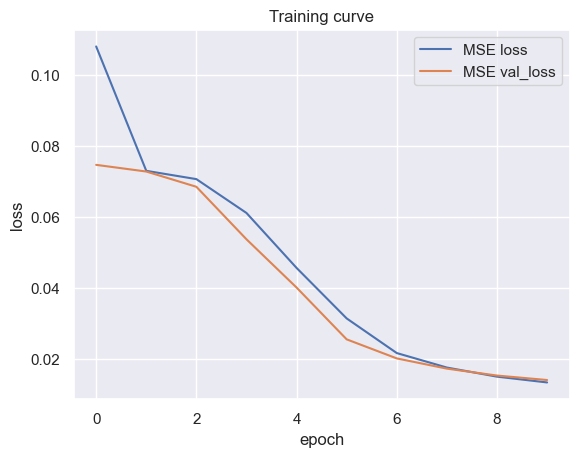

In [105]:
_ = auto_encoder.plot_training_curve()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


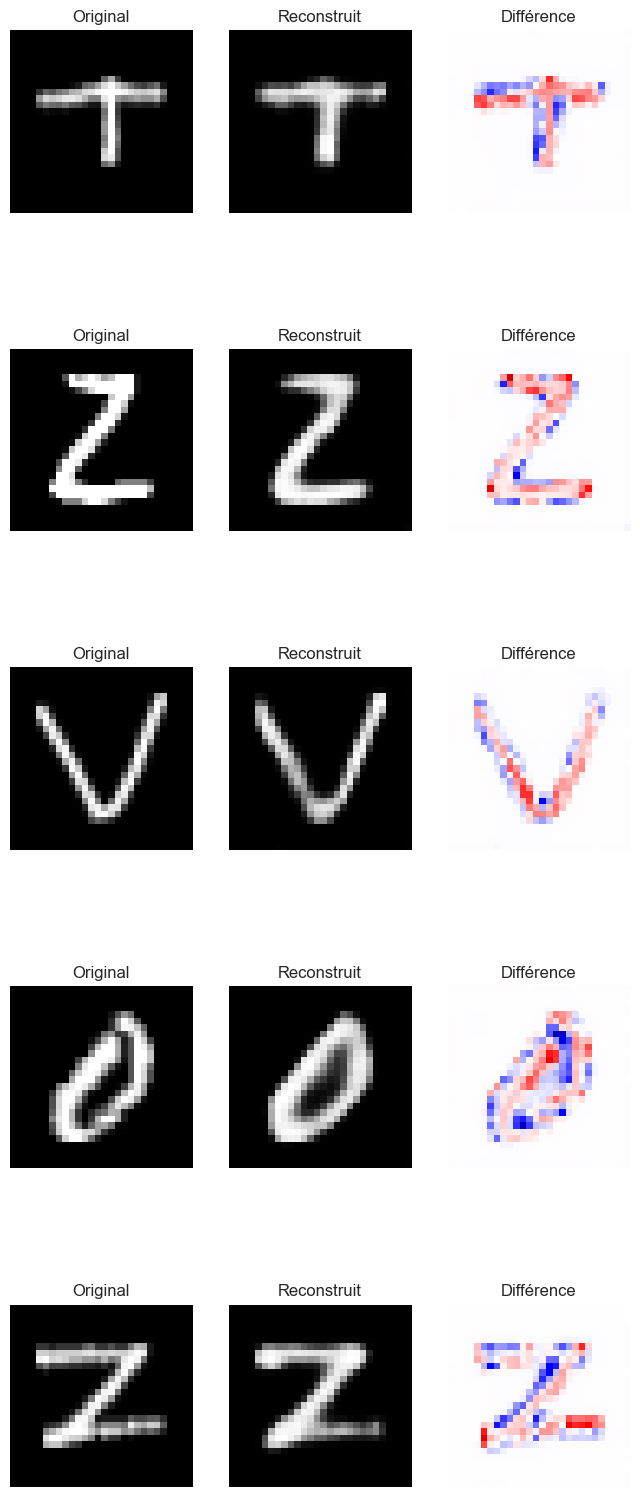

In [107]:
auto_encoder.visualize(x_test)